**Connect google drive**

In [75]:
# Check if NVIDIA GPU is enabled
!nvidia-smi

Wed May 12 07:47:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    35W / 250W |   2567MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

Mounted at /content/gdrive
 blank	   'Colab Notebooks'  'Data test'  'wadah makanan2.zip'   yolov3
'blank 2'   cup2.zip	       Kayu.zip    'wadah makanan.zip'
 cfg	    cup.zip	      'My Drive'    weights


**1) Clone the Darknet**



In [5]:
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15035, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 15035 (delta 11), reused 17 (delta 6), pack-reused 15002
Receiving objects: 100% (15035/15035), 13.45 MiB | 20.89 MiB/s, done.
Resolving deltas: 100% (10210/10210), done.


**2) Compile Darknet using Nvidia GPU**


In [6]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile
!make

/content/darknet
mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:935:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1136:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if 

**3) Extract Images**

In [7]:
# this is where my datasets are stored within my Google Drive (I created a yolov4 folder to store all important files for custom training) 
!ls /mydrive/yolov3

'Azmi cup'   Deteksi_objek_train.cfg   obj.data   'sampah plastik.jpg'
 backup      generate_test.py	       obj.names   test.zip
 botol	     generate_train.py	       obj.zip	   vs.mp4


In [8]:
# copy over both datasets into the root directory of the Colab VM (comment out test.zip if you are not using a validation dataset)
!cp /mydrive/yolov3/obj.zip ../
!cp /mydrive/yolov3/test.zip ../

In [9]:
# unzip the datasets and their contents so that they are now in /darknet/data/ folder
!unzip ../obj.zip -d data/
!unzip ../test.zip -d data/

Archive:  ../obj.zip
  inflating: data/obj/_102208153_499d53be-e6d2-4d7c-a8c2-c70ffc2f90f2.jpg  
  inflating: data/obj/_102208153_499d53be-e6d2-4d7c-a8c2-c70ffc2f90f2.txt  
  inflating: data/obj/_110590069_gettyimages-593275770.jpg  
  inflating: data/obj/_110590069_gettyimages-593275770.txt  
  inflating: data/obj/0_c5a0d7d2-cdd5-41ac-8c8f-f8e9ca0eb52b_1040_500.jpg  
  inflating: data/obj/0_c5a0d7d2-cdd5-41ac-8c8f-f8e9ca0eb52b_1040_500.txt  
  inflating: data/obj/0_d70be78e-bc81-4c5a-b7da-58bc664255fd_1032_774.jpg  
  inflating: data/obj/0_d70be78e-bc81-4c5a-b7da-58bc664255fd_1032_774.txt  
  inflating: data/obj/0_fc3cd1a7-a87c-4804-8026-c6a2e76be6b9_640_640.jpg  
  inflating: data/obj/0_fc3cd1a7-a87c-4804-8026-c6a2e76be6b9_640_640.txt  
  inflating: data/obj/000610ca2148a5ec.jpg  
  inflating: data/obj/000610ca2148a5ec.txt  
  inflating: data/obj/00075e339f3d4f37.jpg  
  inflating: data/obj/00075e339f3d4f37.txt  
  inflating: data/obj/002c60d5fbc94244.jpg  
  inflating: data/obj/002c

**4) Configure Darknet network for training YOLO V3**

i) Cfg File

In [10]:
!cp cfg/yolov3.cfg cfg/yolov3_training.cfg

In [11]:
!sed -i 's/batch=1/batch=64/' cfg/yolov3_training.cfg
!sed -i 's/subdivisions=1/subdivisions=16/' cfg/yolov3_training.cfg
!sed -i 's/max_batches = 500200/max_batches = 10000/' cfg/yolov3_training.cfg
!sed -i '610 s@classes=80@classes=5@' cfg/yolov3_training.cfg
!sed -i '696 s@classes=80@classes=5@' cfg/yolov3_training.cfg
!sed -i '783 s@classes=80@classes=5@' cfg/yolov3_training.cfg
!sed -i '603 s@filters=255@filters=30@' cfg/yolov3_training.cfg
!sed -i '689 s@filters=255@filters=30@' cfg/yolov3_training.cfg
!sed -i '776 s@filters=255@filters=30@' cfg/yolov3_training.cfg

ii) obj.names and obj.data

In [12]:
# upload the obj.names and obj.data files to cloud VM from Google Drive
!cp /content/gdrive/MyDrive/yolov3/obj.names ./data
!cp /content/gdrive/MyDrive/yolov3/obj.data ./data

iii) Generating train.txt and test.txt

The last configuration files needed before we can begin to train our custom detector are the train.txt and test.txt files which hold the relative paths to all our training images and valdidation images.

In [13]:
!cp /content/gdrive/MyDrive/yolov3/generate_train.py ./
!cp /content/gdrive/MyDrive/yolov3/generate_test.py ./

In [14]:
!python generate_train.py
!python generate_test.py

In [15]:
# verify that the newly generated train.txt and test.txt can be seen in our darknet/data folder
!ls data/

9k.tree     giraffe.jpg		      labels		person.jpg  voc.names
coco9k.map  goal.txt		      obj		scream.jpg
coco.names  horses.jpg		      obj.data		test
dog.jpg     imagenet.labels.list      obj.names		test.txt
eagle.jpg   imagenet.shortnames.list  openimages.names	train.txt


**5) Download pre-trained weights for the convolutional layers.**

In [14]:
# Download weights darknet model 53
!wget https://pjreddie.com/media/files/darknet53.conv.74

--2021-05-12 02:43:14--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  51.8MB/s    in 3.0s    

2021-05-12 02:43:17 (51.8 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



**6) Start the training**

In [15]:
# Start the training
!./darknet detector train data/obj.data cfg/yolov3_training.cfg darknet53.conv.74 -dont_show -map

Streaming output truncated to the last 5000 lines.
 total_bbox = 218202, rewritten_bbox = 0.559115 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.846269), count: 5, class_loss = 1.003999, iou_loss = 0.113831, total_loss = 1.117830 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.000000), count: 1, class_loss = 0.007709, iou_loss = 0.000000, total_loss = 0.007709 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.000000), count: 1, class_loss = 0.000057, iou_loss = 0.000000, total_loss = 0.000057 
 total_bbox = 218207, rewritten_bbox = 0.559102 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.812040), count: 8, class_loss = 1.007663, iou_loss = 0.356744, total_loss = 1.364407 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.644491), count: 4, class_loss = 0.816444, iou_loss = 0.450582, total_loss = 1.267026 
v3 (ms

**maP**

In [18]:
!./darknet detector map data/obj.data cfg/yolov3_training.cfg /mydrive/yolov3/backup/yolov3_training_last.weights

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 10

**DETEKSI OBJECT** 

In [21]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline

**Darknet for Python**

In [39]:
# import darknet functions to perform object detections
from darknet import *
# load in our YOLOv3 architecture network
network, class_names, class_colors = load_network("/content/gdrive/MyDrive/yolov3/Deteksi_objek_train.cfg", "/content/darknet/data/obj.data", "/content/gdrive/MyDrive/yolov3/backup/yolov3_training_last.weights")
width = network_width(network)
height = network_height(network)

# darknet helper function to run detection on image
def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # get image ratios to convert bounding boxes to proper size
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  # run model on darknet style image to get detections
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)
  return detections, width_ratio, height_ratio

**YOLOv4 Example on Test Image**

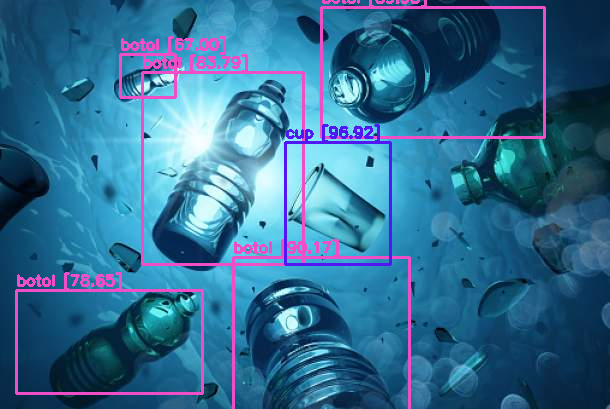

In [40]:
# run test on person.jpg image that comes with repository
image = cv2.imread("/content/gdrive/MyDrive/yolov3/sampah plastik.jpg")
detections, width_ratio, height_ratio = darknet_helper(image, width, height)

for label, confidence, bbox in detections:
  left, top, right, bottom = bbox2points(bbox)
  left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
  cv2.rectangle(image, (left, top), (right, bottom), class_colors[label], 2)
  cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),
                    (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    class_colors[label], 2)
cv2_imshow(image)

**Helper Functions**

Here are a few helper functions defined that will be used to easily convert between different image types within our later steps.

In [41]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

**YOLOv4 on Wecam Images**

In [42]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  
  # call our darknet helper on webcam image
  detections, width_ratio, height_ratio = darknet_helper(img, width, height)

  # loop through detections and draw them on webcam image
  for label, confidence, bbox in detections:
    left, top, right, bottom = bbox2points(bbox)
    left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
    cv2.rectangle(img, (left, top), (right, bottom), class_colors[label], 2)
    cv2.putText(img, "{} [{:.2f}]".format(label, float(confidence)),
                      (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                      class_colors[label], 2)
  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


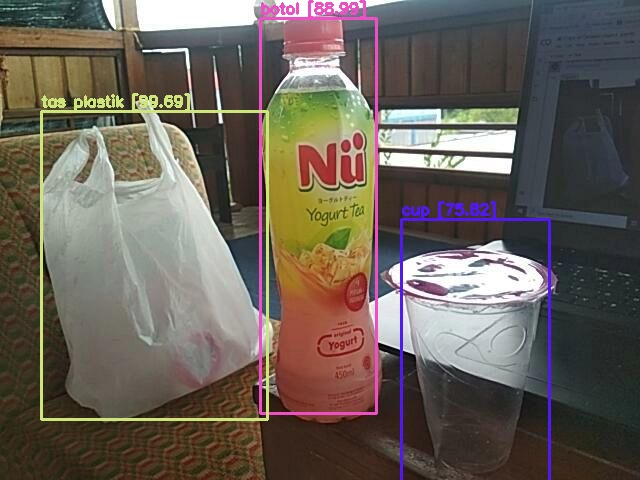

In [72]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

**YOLOv4 on Webcam Videos**

In [73]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [74]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # call our darknet helper on video frame
    detections, width_ratio, height_ratio = darknet_helper(frame, width, height)

    # loop through detections and draw them on transparent overlay image
    for label, confidence, bbox in detections:
      left, top, right, bottom = bbox2points(bbox)
      left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
      bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), class_colors[label], 2)
      bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
                        (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        class_colors[label], 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>